# Hail Conv Net Filter Activations

This notebook contains the examples that activate each convolutional filter in the last layer of a hail neural net.

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
import xarray as xr
from deepsky.data import load_storm_patch_data
from deepsky.gan import normalize_multivariate_data, unnormalize_multivariate_data
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join, exists

Using TensorFlow backend.


In [2]:
config_file = "/users/dgagne/deepsky/config/spatial_storm_model_config.yaml"
with open(config_file) as config_obj:
    config = yaml.load(config_obj)

Load storm data from netCDF and normalize it.

In [3]:
data_path = "/users/dgagne/ncar_control_storm_patches/"
input_variables = config["input_variables"]
num_proc = 4
print("Loading data")
storm_data, storm_meta = load_storm_patch_data(data_path, input_variables, num_proc)
storm_norm_data, storm_scaling_values = normalize_multivariate_data(storm_data)

Loading data
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050500_mem_01.nc 255
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050600_mem_01.nc 935
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050700_mem_01.nc 850
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050800_mem_01.nc 1300
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050900_mem_01.nc 1935
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051200_mem_01.nc 1015
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051000_mem_01.nc 2010
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051500_mem_01.nc 690
/us

In [4]:
model_path = "/scratch/dgagne/spatial_storm_results_20171220/"
sample = 3
hail_cnn = load_model(join(model_path, "hail_conv_net_sample_{0:03d}.h5".format(sample)))

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
__________

In [6]:
dense_weights = hail_cnn.layers[-2].get_weights()[0].reshape(4,4,128)

In [24]:
dense_weights.mean(axis=0).mean(axis=0).argmax()

42

(array([ 1.,  0.,  0.,  0.,  2.,  4.,  3.,  3.,  4.,  8.,  5., 15., 10.,
        19., 16., 13., 13., 15., 13., 14., 14., 13., 14., 23., 11., 21.,
        13., 15., 17., 16., 22.,  9., 10., 15., 18., 15., 17., 12., 21.,
        10.,  6., 14.,  9.,  3.,  7.,  2.,  1.,  2.,  2.,  2.]),
 array([-0.05051645, -0.04871689, -0.04691732, -0.04511776, -0.0433182 ,
        -0.04151863, -0.03971907, -0.03791951, -0.03611994, -0.03432038,
        -0.03252082, -0.03072126, -0.02892169, -0.02712213, -0.02532257,
        -0.023523  , -0.02172344, -0.01992388, -0.01812431, -0.01632475,
        -0.01452519, -0.01272563, -0.01092606, -0.0091265 , -0.00732694,
        -0.00552737, -0.00372781, -0.00192825, -0.00012868,  0.00167088,
         0.00347044,  0.00527   ,  0.00706957,  0.00886913,  0.01066869,
         0.01246826,  0.01426782,  0.01606738,  0.01786695,  0.01966651,
         0.02146607,  0.02326563,  0.0250652 ,  0.02686476,  0.02866432,
         0.03046389,  0.03226345,  0.03406301,  0.03586258,

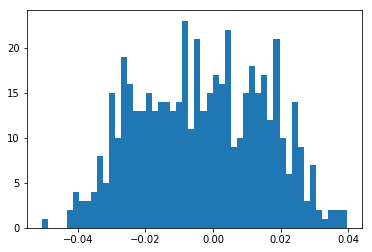

In [10]:
plt.hist(dense_weights[1:-1, 1:-1].ravel(), 50)

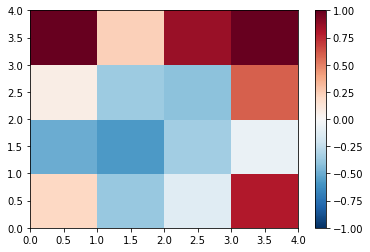

In [11]:
plt.pcolormesh(dense_weights.sum(axis=-1), vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar()

In [15]:
np.unravel_index(12, (4,4))

(3, 0)

In [23]:
np.where(dense_weights > 0.02, 1, 0).sum(axis=-1).argmax()

12

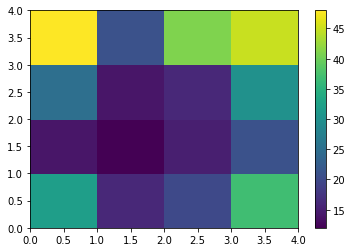

In [12]:
plt.pcolormesh(np.where(dense_weights > 0.02, 1, 0).sum(axis=-1))
plt.colorbar()

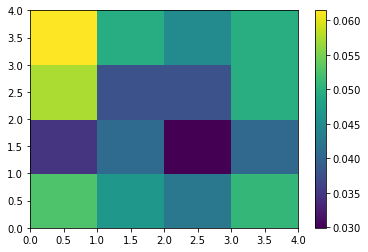

In [140]:
plt.pcolormesh(dense_weights.max(axis=-1))
plt.colorbar()

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.03, 0.03, 0.94, 0.94, hspace=0, wspace=0)
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(dense_weights[:, :, a], vmin=-0.06, vmax=0.06, cmap="RdBu_r")

In [5]:
def activated_analogs(norm_data, cnn_model, num_analogs=16, filter_index=(0, 0), dense_layer_index=-2,
                      conv_layer_index=-6):
    """
    For a given convolutional neural network, identify the examples that most activate a given set of
    neurons in a convolutional layer.

    Args:
        norm_data: Normalized input data for the convolutional neural network
        cnn_model: Keras convolutional neural network model object
        num_analogs: Number of activated input examples to store for each neuron
        filter_index: Spatial array index of convolution filters being evaluated
        dense_layer_index: Index of the final dense layer that connects the convolutions and outputs
        conv_layer_index: Index of the activation of the final convolutional layer.

    Returns:
        dense_weights (array of weight values), top_analog_ids (input data indices associated with each neuron),
        top_analog_activations (the magnitude of the activation), top_analog_gradients (gradients with respect
        to the input for each of the top analogs)
    """
    dense_weights = pd.Series(cnn_model.layers[dense_layer_index].get_weights()[0].reshape(
        cnn_model.layers[conv_layer_index].output_shape[1:])[filter_index], name="Weights")
    top_analog_ids = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs), dtype=int),
                                  columns=["Analog_ID_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_activations = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs)),
                                          columns=["Analog_Act_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_gradients = np.zeros([dense_weights.shape[-1], num_analogs] + list(norm_data.shape[1:]))
    for w in range(dense_weights.shape[-1]):
        print(w, dense_weights[w])
        filter_out = cnn_model.layers[conv_layer_index].output[:, filter_index[0], filter_index[1], w]
        act_func = K.function([cnn_model.input, K.learning_phase()],
                              [filter_out])
        loss = (filter_out - 2) ** 2
        grad = K.gradients(loss, cnn_model.input)[0]
        grad /= K.maximum(K.std(grad), K.epsilon())
        grad_func = K.function([cnn_model.input, K.learning_phase()], [grad])
        max_acts = act_func([norm_data, 0])[0]
        top_analog_ids.loc[w] = np.argsort(max_acts)[::-1][:num_analogs]
        top_analog_activations.loc[w] = max_acts[top_analog_ids.loc[w]]
        top_analog_gradients[w] = grad_func([norm_data[top_analog_ids.loc[w]], 0])[0]
    combined_info = pd.concat([top_analog_ids, top_analog_activations, dense_weights], axis=1)
    return combined_info, top_analog_gradients

In [6]:
analog_info, analog_gradients = activated_analogs(storm_norm_data, hail_cnn, filter_index=(1, 1))

0 -0.013771823
1 -0.016664773
2 0.018412651
3 -0.014204214
4 -0.004878448
5 -0.017432041
6 -0.028050717
7 0.013670226
8 -0.01099966
9 -0.01769745
10 0.0020298182
11 -0.0063217413
12 -0.0032234164
13 0.017209124
14 0.015342723
15 0.01590437
16 0.018054202
17 0.010376171
18 -0.007422329
19 -0.008889999
20 0.014299571
21 -0.0021572066
22 0.00471891
23 -0.023546934
24 -0.017199207
25 -0.030310424
26 -0.0124488855
27 -0.0027411627
28 0.011502943
29 -0.020338662
30 0.015841624
31 -0.009848939
32 0.020852013
33 -0.01605926
34 0.020708364
35 -0.014048111
36 0.006849356
37 -0.023456397
38 0.022917919
39 -0.028413305
40 0.015478894
41 -0.013567386
42 -0.024912445
43 -0.02840139
44 0.008369038
45 0.021024337
46 0.016787654
47 -0.008739818
48 0.020127444
49 -0.033703852
50 0.004379493
51 0.022972299
52 0.0010101943
53 0.015707297
54 -0.0023341351
55 0.01573416
56 -0.012758902
57 5.9397462e-05
58 0.010740341
59 0.012729107
60 -0.013539034
61 0.011588308
62 0.015188462
63 -0.02914968
64 0.008732372


In [8]:
analog_info

,Analog_ID_00,Analog_ID_01,Analog_ID_02,Analog_ID_03,Analog_ID_04,Analog_ID_05,Analog_ID_06,Analog_ID_07,Analog_ID_08,Analog_ID_09,...,Analog_Act_07,Analog_Act_08,Analog_Act_09,Analog_Act_10,Analog_Act_11,Analog_Act_12,Analog_Act_13,Analog_Act_14,Analog_Act_15,Weights
0,959,930,928,968,958,929,991,974,987,973,...,3.999580,3.952137,3.899872,3.891684,3.874421,3.866189,3.865011,3.851233,3.794062,-0.003051
1,2636,2618,2627,2626,2596,561,514,2634,513,2617,...,5.468894,5.337132,5.271184,5.203004,5.158315,5.020155,4.978301,4.963313,4.959144,0.031874
2,960,930,969,2575,917,2577,985,968,2553,991,...,4.784540,4.628753,4.576219,4.567082,4.550066,4.508023,4.473456,4.403178,4.393889,-0.016505
3,2577,514,2553,2576,1502,540,1418,2619,1421,2598,...,4.060267,4.035750,3.968970,3.938068,3.909888,3.902527,3.893346,3.875039,3.861919,-0.000294
4,930,959,929,928,958,932,991,954,985,953,...,5.876476,5.807010,5.794079,5.750627,5.693877,5.618945,5.587558,5.492625,5.417387,-0.030226
5,930,1261,929,969,970,956,1023,928,959,958,...,2.755754,2.745869,2.741323,2.706426,2.678753,2.678328,2.670632,2.662938,2.662286,0.004787
6,969,930,994,917,919,960,945,985,968,993,...,3.266243,3.257754,3.220477,3.215302,3.140146,3.133519,3.121495,3.080768,3.046874,0.024603
7,930,928,932,959,958,991,973,960,988,987,...,3.426267,3.425149,3.372112,3.371625,3.370289,3.341526,3.321370,3.305146,3.304513,-0.023280
8,496,2627,197,176,175,2636,2576,514,2618,524,...,5.765511,5.701661,5.595890,5.581326,5.528557,5.522685,5.521310,5.463202,5.411196,0.015771
9,4273,4338,1459,598,620,597,2672,4288,1643,5539,...,4.608346,4.575113,4.521189,4.468534,4.436677,4.371905,4.333160,4.309670,4.298259,-0.032241


In [7]:
data_acts = np.zeros((storm_norm_data.shape[0], 2))
for i, w in enumerate([104, 38]):
    filter_out = hail_cnn.layers[-6].output[:, 1, 1, w]
    act_func = K.function([hail_cnn.input, K.learning_phase()],
                              [filter_out])
    data_acts[:, i] = act_func([storm_norm_data, 0])[0]

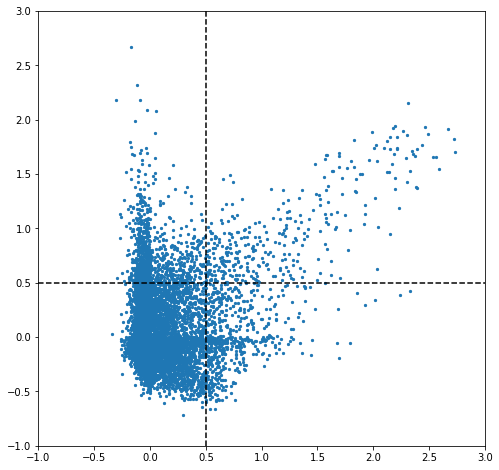

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(data_acts[:, 0], data_acts[:, 1], 5)
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.plot(np.ones(10) * 0.5, np.linspace(-1, 3, 10), 'k--')
plt.plot(np.linspace(-1, 3, 10), np.ones(10) * 0.5,  'k--')

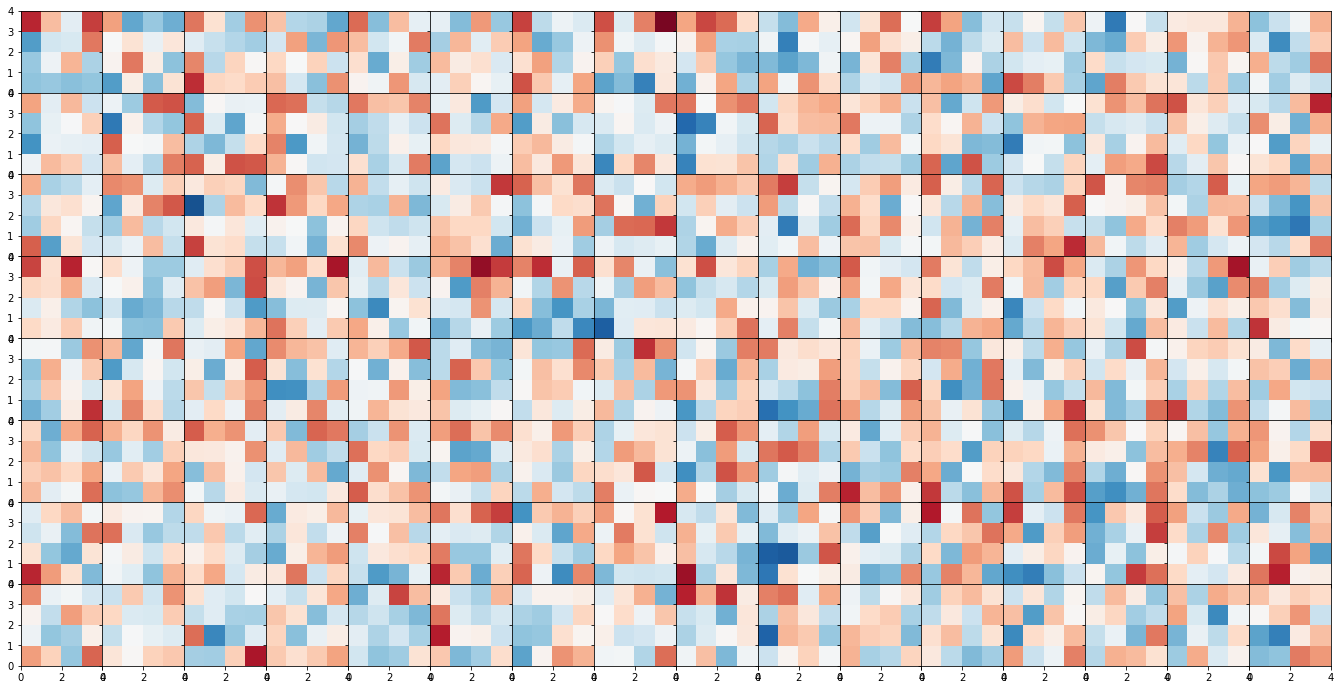

In [13]:
cfeature.COLORS

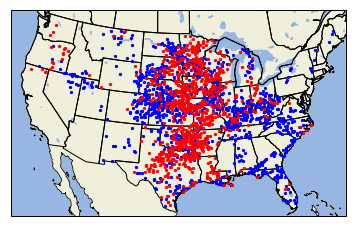

In [14]:
crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
ax.coastlines('50m', linewidth=0.8, zorder=4)
idxs = data_acts[:, 0] > 1
idxs_2 = data_acts[:, 1] > 1
ax.scatter(storm_meta.loc[idxs_2, "center_lon"], storm_meta.loc[idxs_2, "center_lat"], 5, "blue", transform=crs, zorder=5)
ax.scatter(storm_meta.loc[idxs, "center_lon"], storm_meta.loc[idxs, "center_lat"], 5, "red",transform=crs, zorder=6)
ax.set_extent((-120, -74, 23, 50))

In [10]:
idxs = data_acts[:, 0] > 0.5
idxs_2 = data_acts[:, 1] > 0.5
lons = np.arange(-120, -74.25, 0.5)
lats = np.arange(20, 50.25, 0.5)
lon_grid, lat_grid = np.meshgrid(lons, lats)
out_points = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T
kd1 = KernelDensity(bandwidth=2, metric="euclidean")
kd1.fit(storm_meta.loc[idxs, ["center_lat", "center_lon"]])
kd2 = KernelDensity(bandwidth=2, metric="euclidean")
kd2.fit(storm_meta.loc[idxs_2,["center_lat", "center_lon"]])
out_1 = np.exp(kd1.score_samples(out_points))
out_2 = np.exp(kd2.score_samples(out_points))

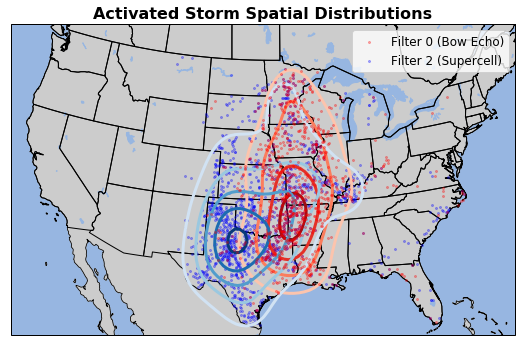

In [31]:
fig = plt.figure(figsize=(10, 6))
crs = ccrs.PlateCarree()
ax = fig.add_axes([0, 0, 0.7, 1], projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="0.8")
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
ax.coastlines('50m', linewidth=0.8, zorder=4)
plt.contour(lon_grid, lat_grid, out_1.reshape(lon_grid.shape), 
            5, vmin=np.percentile(out_2, 10), vmax=out_1.max(), transform=crs, 
            zorder=6, linewidths=3, cmap="Reds", )
plt.contour(lon_grid, lat_grid, out_2.reshape(lon_grid.shape), 
            5, vmin=np.percentile(out_2, 10), vmax=out_2.max(), transform=crs, 
            zorder=6, linewidths=3, cmap="Blues", )
ax.scatter(storm_meta.loc[idxs, "center_lon"], storm_meta.loc[idxs, "center_lat"], 4, "red", alpha=0.3, 
           transform=crs, zorder=6, label="Filter 0 (Bow Echo)")
ax.scatter(storm_meta.loc[idxs_2, "center_lon"], storm_meta.loc[idxs_2, "center_lat"], 
           4, "blue", alpha=0.3, transform=crs, zorder=5, label="Filter 2 (Supercell)")

ax.set_extent((-120, -74, 23, 50))
ax.legend(loc=0, fontsize=12)
ax.set_title("Activated Storm Spatial Distributions", fontsize=16, fontweight="bold")
plt.savefig("activation_spatial_dist.pdf", bbox_inches="tight")

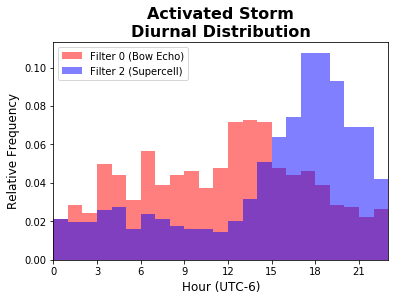

In [30]:
fig, ax_2 = plt.subplots(1, 1, figsize=(6, 4))
ax_2.hist((pd.DatetimeIndex(storm_meta.loc[idxs, "valid_dates"]).hour - 6) % 24, np.arange(0, 25), 
          alpha=0.5, color="red", density=True, lw=2, label="Filter 0 (Bow Echo)")
ax_2.hist((pd.DatetimeIndex(storm_meta.loc[idxs_2, "valid_dates"]).hour - 6) % 24, np.arange(0, 25), 
         alpha=0.5, color="blue", density=True, lw=2, label="Filter 2 (Supercell)")
ax_2.set_xticks(np.arange(0, 24, 3))
ax_2.set_xlim(0, 23)
ax_2.legend(loc=0)
ax_2.set_xlabel("Hour (UTC-6)", fontsize=12)
ax_2.set_ylabel("Relative Frequency", fontsize=12)
ax_2.set_title("Activated Storm\nDiurnal Distribution", fontsize=16, fontweight="bold")
plt.savefig("activation_hour_dist.pdf", bbox_inches="tight")

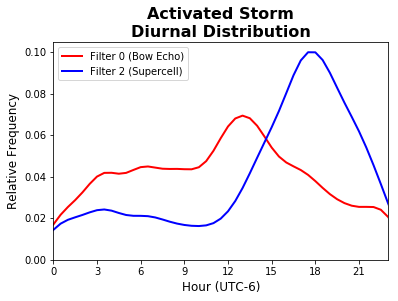

In [32]:
fig, ax_2 = plt.subplots(1, 1, figsize=(6, 4))
kd_time_0 = KernelDensity(bandwidth=1)
kd_time_0.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_1 = KernelDensity()
kd_time_1.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_2, "valid_dates"]).hour - 6) % 24, axis=1))
times = np.arange(0, 25, 0.5)
ax_2.plot(times, np.exp(kd_time_0.score_samples(times.reshape(-1, 1))), color="red", linewidth=2, label="Filter 0 (Bow Echo)")
ax_2.plot(times, np.exp(kd_time_1.score_samples(times.reshape(-1, 1))), color="blue", linewidth=2, label="Filter 2 (Supercell)")
ax_2.set_xticks(np.arange(0, 24, 3))
ax_2.set_xlim(0, 23)
ax_2.legend(loc=0)
ax_2.set_xlabel("Hour (UTC-6)", fontsize=12)
ax_2.set_ylabel("Relative Frequency", fontsize=12)
ax_2.set_title("Activated Storm\nDiurnal Distribution", fontsize=16, fontweight="bold")
plt.savefig("activation_hour_dist_kde.pdf", bbox_inches="tight")

In [8]:
analog_info["Weights"].sort_values()[::-1]

104    0.023381
51     0.022972
38     0.022918
112    0.022721
72     0.021976
45     0.021024
32     0.020852
34     0.020708
48     0.020127
83     0.018656
2      0.018413
16     0.018054
102    0.017466
13     0.017209
46     0.016788
15     0.015904
30     0.015842
55     0.015734
53     0.015707
40     0.015479
14     0.015343
119    0.015270
62     0.015188
20     0.014300
80     0.014081
7      0.013670
73     0.013123
115    0.013066
59     0.012729
108    0.011689
         ...   
98    -0.018986
29    -0.020339
70    -0.020948
66    -0.022611
37    -0.023456
23    -0.023547
117   -0.023817
101   -0.024369
87    -0.024438
90    -0.024749
71    -0.024775
42    -0.024912
103   -0.026975
99    -0.027146
6     -0.028051
93    -0.028173
43    -0.028401
39    -0.028413
107   -0.028464
63    -0.029150
121   -0.030057
86    -0.030105
125   -0.030241
25    -0.030310
116   -0.030411
88    -0.031509
69    -0.033407
49    -0.033704
65    -0.034704
100   -0.037076
Name: Weights, Length: 1

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


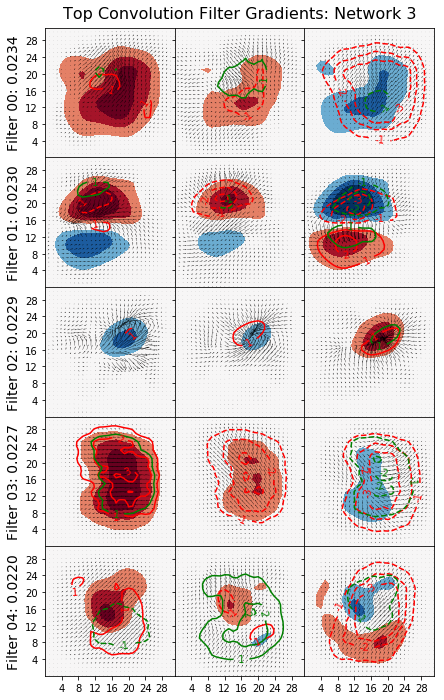

In [14]:
fig, axes = plt.subplots(5, 3, figsize=(6, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
ranked_weights = analog_info["Weights"].sort_values()[::-1].index
p_levels = [500, 700, 850]
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    ax.contourf(gaussian_filter(analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1), contours, extend="both", cmap="RdBu_r")
    tc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1), contours, colors="red")
    ax.clabel(tc, fmt="%0.0f")
    dc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1), contours, colors="green")
    ax.clabel(dc, fmt="%0.0f")
    ax.quiver(gaussian_filter(analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 1),
             gaussian_filter(analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 1))
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.4f}".format(w, analog_info.loc[ranked_weights[w], "Weights"]),
                  fontsize=14)
    ax.set_yticks(np.arange(4, 32, 4))
    ax.set_xticks(np.arange(4, 32, 4))
    if w == 5:
        ax.set_xlabel("{0:d} mb".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
plt.suptitle("Top Convolution Filter Gradients: Network {0:d}".format(sample), fontsize=16)
plt.savefig("top_filter_gradients_{0:02d}.pdf".format(sample), dpi=300, bbox_inches="tight")

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


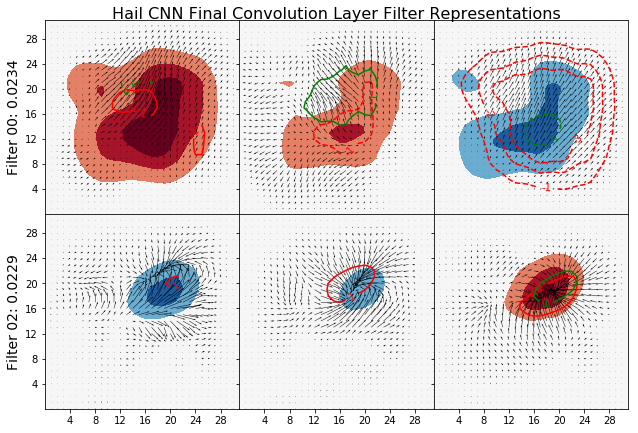

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
ranked_weights = analog_info["Weights"].sort_values()[::-1].index[[0,2]]
f_number = [0, 2]
p_levels = [500, 700, 850]
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    ax.contourf(gaussian_filter(analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1), contours, extend="both", cmap="RdBu_r")
    tc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1), contours, colors="red")
    ax.clabel(tc, fmt="%0.0f")
    dc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1), contours, colors="green")
    ax.clabel(dc, fmt="%0.0f")
    ax.quiver(gaussian_filter(analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 1),
             gaussian_filter(analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 1))
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.4f}".format(f_number[w], analog_info.loc[ranked_weights[w], "Weights"]),
                  fontsize=14)
    ax.set_yticks(np.arange(4, 32, 4))
    ax.set_xticks(np.arange(4, 32, 4))
    if w == 5:
        ax.set_xlabel("{0:d} mb".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
plt.suptitle("Hail CNN Final Convolution Layer Filter Representations", fontsize=16)
plt.savefig("top_filter_gradients_{0:02d}_reduced.pdf".format(sample), dpi=300, bbox_inches="tight")

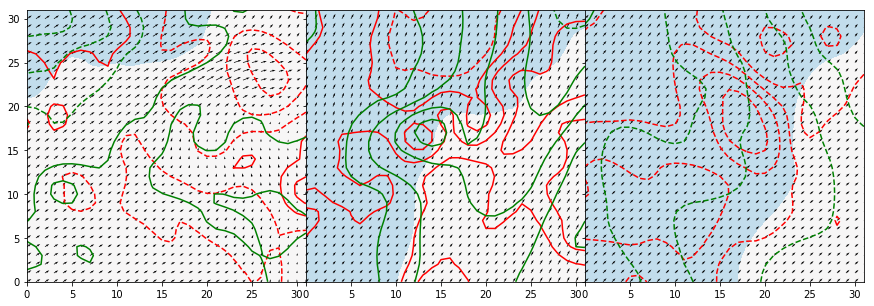

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = [-3, -2, -1, -0.5, 0.5, 1, 2, 3]
weight = 97
weight_analogs = analog_info.iloc[weight, 0:16].values.astype(int)
for a, ax in enumerate(axes):
    ax.contourf(gaussian_filter(storm_norm_data[weight_analogs, :, :, 0 + a][1], 1), contours, extend="both", cmap="RdBu_r")
    ax.contour(gaussian_filter(storm_norm_data[weight_analogs, :, :, 3 + a][1], 1), 5, colors="red")
    ax.contour(gaussian_filter(storm_norm_data[weight_analogs, :, :, 6 + a][1], 1), 5, colors="green")
    ax.quiver(gaussian_filter(storm_norm_data[weight_analogs, :, :, 9 + a][1], 1),
             gaussian_filter(storm_norm_data[weight_analogs, :, :, 12 + a][1], 1))

In [16]:
num_ex = 16
top_max_example_ids = np.zeros((dense_weights.shape[-1], num_ex), dtype=int)
top_max_acts = np.zeros((dense_weights.shape[-1], num_ex))
top_max_gradients = np.zeros((dense_weights.shape[-1], num_ex, 32, 32, 15))

for w in range(dense_weights.shape[-1]):
    print(w)
    act_func = K.function([hail_cnn.input, K.learning_phase()], 
                          [hail_cnn.layers[-6].output[:, 3, 0, w]])
    max_loss = (hail_cnn.layers[-6].output[:, 3, 0, w]- 4) ** 2
    max_grad = K.gradients(max_loss, hail_cnn.input)
    max_grad_func = K.function([hail_cnn.input, K.learning_phase()], max_grad)
    max_acts = act_func([storm_norm_data, 0])[0]
    top_max_example_ids[w] = np.argsort(max_acts)[::-1][:num_ex]
    top_max_acts[w] = max_acts[top_max_example_ids[w]]
    top_max_gradients[w] = max_grad_func([storm_norm_data[top_max_example_ids[w]]])[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [35]:
hail_cnn.layers[-6].output[:, :, :, 4]

<tf.Tensor 'strided_slice_129:0' shape=(?, 4, 4) dtype=float32>

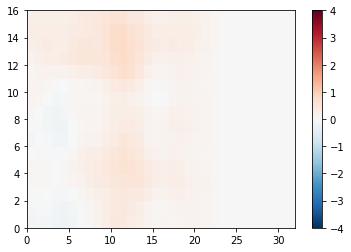

In [134]:
plt.pcolormesh(gaussian_filter(top_max_gradients[63,:, :, :, 2].mean(axis=1) / top_max_gradients[63].std(), 1), 
               vmin=-4, vmax=4, cmap="RdBu_r")
plt.colorbar()

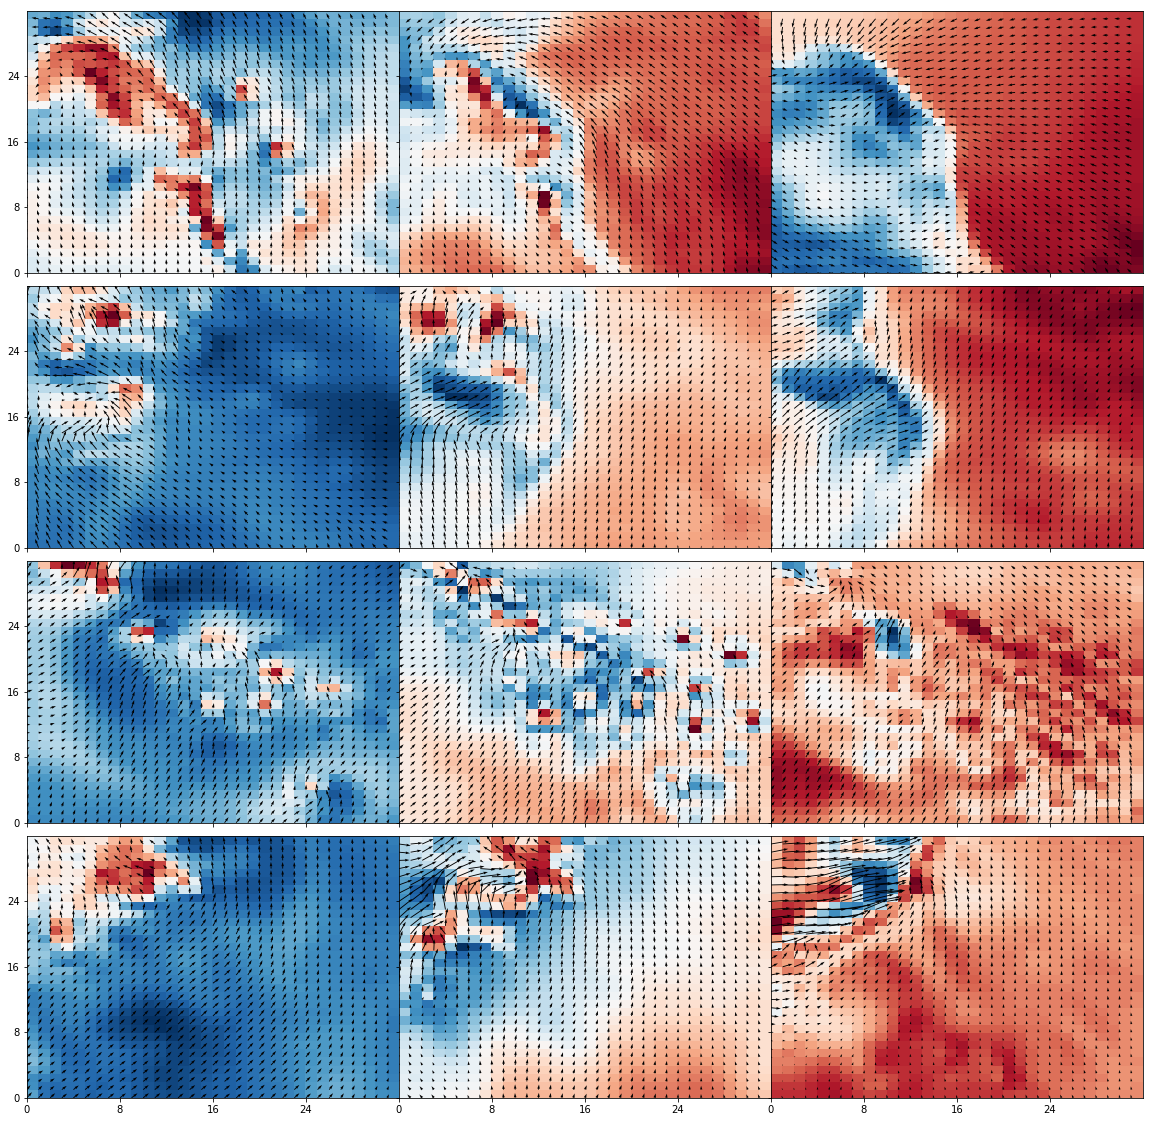

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3])
for w, ex_id in enumerate(top_max_example_ids[42][:4]):
    for l in range(3):
        axes[w, l].pcolormesh(storm_norm_data[ex_id, :, :, 3 + l], cmap="RdBu_r")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 3 + l], contours, colors="red")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 6 + l], contours, colors="green")
        axes[w, l].quiver(storm_norm_data[ex_id, :, :, 9 + l], storm_norm_data[ex_id, :, :, 12 + l])
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

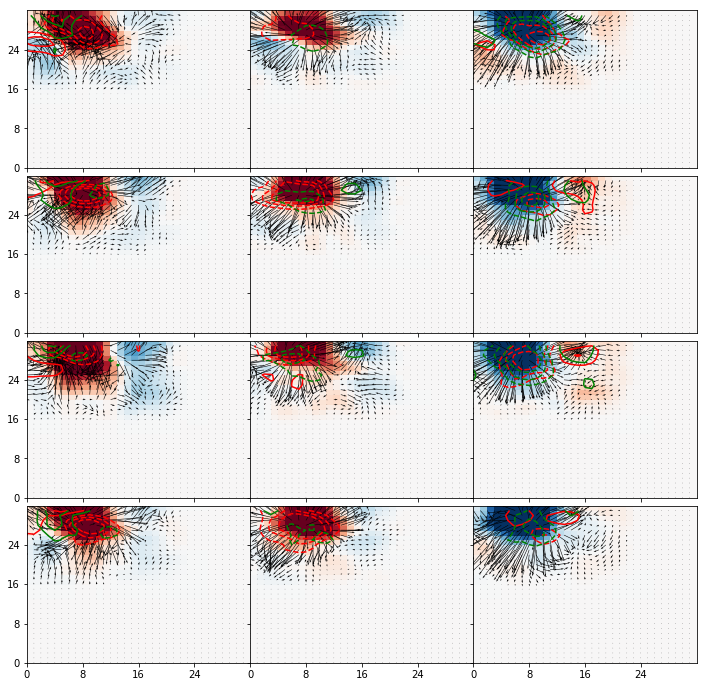

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
for w, ex_id in enumerate(top_max_example_ids[c_filter][:4]):
    scale = top_max_gradients[c_filter, w].std()
    for l in range(3):
        axes[w, l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, w, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 3 + l] / scale, 1), contours, colors="red")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 6 + l]/ scale, 1), contours, colors="green")
        axes[w, l].quiver(gaussian_filter(top_max_gradients[c_filter, w, :, :, 9 + l] / scale, 1) , 
                          gaussian_filter(top_max_gradients[c_filter, w, :, :, 12 + l] / scale,1))
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

ValueError: too many values to unpack (expected 2)

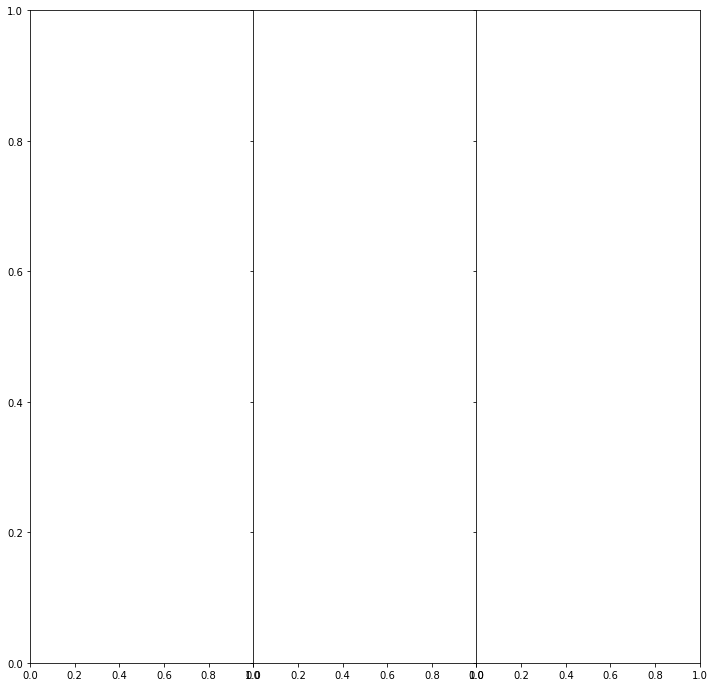

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
scale = top_max_gradients[c_filter].std()
w = 0
for l in range(3):
    axes[l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, :, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 3 + l].mean(axis=1) / scale, 1), contours, colors="red")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 6 + l].mean(axis=1)/ scale, 1), contours, colors="green")
    axes[l].quiver(gaussian_filter(top_max_gradients[c_filter, :, :, :, 9 + l].mean(axis=1) / scale, 1) , 
                      gaussian_filter(top_max_gradients[c_filter, :, :, :, 12 + l].mean(axis=1) / scale,1))
    axes[l].set_yticks(np.arange(0, 32, 8))
    axes[l].set_xticks(np.arange(0, 32, 8))

In [146]:
dense_weights[0, 0].argmax()

90

In [86]:
top_max_example_ids[63]

array([4477, 4468, 4476, 4469,  959,  960, 4466, 5119,  930,  958, 1017,
        975,  928,  990,  961,  929])

In [138]:
top_max_gradients[0, w, :, :, 9 + l].shape

(32, 32)